==============================================================================
# 1. INSTALAÇÃO E IMPORTAÇÃO
==============================================================================

In [13]:
!pip install pypdf

In [14]:
!pip install sentence_transformers

In [15]:
pip install --upgrade numpy pandas scipy matplotlib

In [16]:
pip install -q voyageai

In [17]:
import voyageai

In [18]:
from sentence_transformers import SentenceTransformer

In [19]:
import os
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pypdf import PdfReader
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import google.generativeai as genai
from google.api_core import exceptions
from sklearn.manifold import TSNE
from google.colab import userdata
from google.colab import drive
import openai

In [20]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

In [21]:
import math

In [22]:
import plotly.express as px

In [23]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler

In [24]:
# CONFIGURAÇÕES GERAIS
pd.set_option('display.max_colwidth', None)
tqdm.pandas()

# SUAS CHAVES AQUI
OPENAI_KEY = userdata.get('OPENAI_API_KEY')
GOOGLE_KEY = userdata.get('GOOGLE_API_KEY')
VOYAGE_KEY = userdata.get('VOYAGE_KEY')

# Configuração dos Clientes
import openai
client_openai = openai.Client(api_key=OPENAI_KEY)
genai.configure(api_key=GOOGLE_KEY)

# Montar Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


==============================================================================
# 2. EXTRATOR DE PARÁGRAFOS PERFEITOS (GROUND TRUTH)
==============================================================================

In [25]:
def extrair_cpc_avancado(caminho_pdf):
    print(f"📖 Lendo PDF: {caminho_pdf}...")
    reader = PdfReader(caminho_pdf)
    texto_completo = ""
    for page in reader.pages:
        texto_completo += page.extract_text() + "\n"

    lines = texto_completo.split('\n')
    chunks = []

    current_chunk = ""
    current_chapter = "PREAMBULO"
    current_type = "TEXTO"

    # Regex Poderosos
    regex_capitulo = re.compile(r'^\s*(CAPÍTULO|CHAPTER)\s+([IVX]+|\d+)', re.IGNORECASE)
    #regex_item = re.compile(r'^\s*(\d+\.(\d+\.)*|[a-z]\)|Item\s\d+)', re.IGNORECASE)
    regex_item = re.compile(r'^\s*(\d+(\.\d+)*\.?|[a-z]\)|Item\s\d+(\.\d+)*)(?=\s|$)', re.IGNORECASE)
    regex_tabela = re.compile(r'^\s*(Tabela|Quadro)\s+\d+', re.IGNORECASE)

    for line in lines:
        line = line.strip()
        if not line or (line.isdigit() and len(line) < 4): continue

        # A. Mudança de Capítulo
        if regex_capitulo.match(line):
            if current_chunk:
                chunks.append({'texto': current_chunk, 'capitulo': current_chapter, 'tipo': current_type})
                current_chunk = ""
            current_chapter = line
            current_type = "TEXTO"
            continue

        # B. Detecção de Tabela (O "Expurgo")
        if regex_tabela.match(line):
            if current_chunk:
                chunks.append({'texto': current_chunk, 'capitulo': current_chapter, 'tipo': current_type})
            current_chunk = line
            current_type = "TABELA"
            continue

        # C. Novo Item (Parágrafo Lógico)
        if regex_item.match(line):
            if current_chunk:
                chunks.append({'texto': current_chunk, 'capitulo': current_chapter, 'tipo': current_type})
            current_chunk = line
            current_type = "TEXTO" # Volta a ser texto
        else:
            if current_chunk: current_chunk += " " + line
            else: current_chunk = line

    if current_chunk:
        chunks.append({'texto': current_chunk, 'capitulo': current_chapter, 'tipo': current_type})

    return pd.DataFrame(chunks)

# --- EXECUÇÃO DA LEITURA ---
caminho_arquivo = "/content/drive/My Drive/573_CPC00(R2).pdf" # Ajuste seu caminho
try:
    df = extrair_cpc_avancado(caminho_arquivo)
    print(f"✅ Extração Concluída! Total de Parágrafos Lógicos: {len(df)}")

    # Validação de Tamanho (Seu pedido: "Avisar se passar do permitido")
    # Limite seguro aprox: 8000 chars (~2000 tokens) para a maioria dos modelos
    LIMIT_CHAR = 8000
    gigantes = df[df['texto'].str.len() > LIMIT_CHAR]

    if not gigantes.empty:
        print(f"⚠️ ATENÇÃO: {len(gigantes)} parágrafos excederam {LIMIT_CHAR} caracteres.")
        print("Isso pode dar erro na API. Considere quebrar manualmente estes itens:")
        print(gigantes['texto'].str[:100].values)
    else:
        print("✅ Tamanhos de chunks dentro dos limites seguros.")

except Exception as e:
    print(f"❌ Erro: {e}")

📖 Lendo PDF: /content/drive/My Drive/573_CPC00(R2).pdf...
✅ Extração Concluída! Total de Parágrafos Lógicos: 352
⚠️ ATENÇÃO: 1 parágrafos excederam 8000 caracteres.
Isso pode dar erro na API. Considere quebrar manualmente estes itens:
<ArrowStringArray>
['Tabela 6.1 – Resumo de informações fornecidas por bases de mensuração específicas Ativos Balanço pat']
Length: 1, dtype: str


In [26]:
# --- FILTRAGEM DE SEGURANÇA (Adicione isso logo após criar o df) ---
print(f"Total de linhas extraídas: {len(df)}")
print(f"Linhas marcadas como TABELA: {len(df[df['tipo'] == 'TABELA'])}")

# Remove as tabelas do dataset principal
df = df[df['tipo'] == 'TEXTO'].copy().reset_index(drop=True)
print(f"Total limpo para análise: {len(df)}")

Total de linhas extraídas: 352
Linhas marcadas como TABELA: 4
Total limpo para análise: 348


==============================================================================
# 3. CLASSIFICAÇÃO POR CAPÍTULOS
==============================================================================

In [28]:
# Vamos ver quais capítulos o extrator achou para criar o mapa
print("\nCapítulos Encontrados:")
print(df['capitulo'].unique())

# MAPA DE DE/PARA (Ajuste conforme os capítulos que aparecerem no print acima)
# A ideia é agrupar em classes macro para o gráfico ficar legível
mapa_classes = {
    'PREAMBULO': 'INTRODUCAO',
    'CAPÍTULO 1': 'OBJETIVOS',
    'CAPÍTULO 2': 'CARACTERISTICAS', # Qualitativas
    'CAPÍTULO 3': 'DEMONSTRACOES',
    'CAPÍTULO 4': 'ELEMENTOS',       # Onde estão Ativo/Passivo (Ouro!)
    'CAPÍTULO 5': 'RECONHECIMENTO',
    'CAPÍTULO 6': 'MENSURACAO',
    'CAPÍTULO 7': 'APRESENTACAO',
    'CAPÍTULO 8': 'CONCEITO_CAPITAL'
}

# Função flexível para mapear (pega "CAPÍTULO 4 - BLA BLA" e acha "CAPÍTULO 4")
def classificar_por_capitulo(texto_capitulo):
    texto_upper = texto_capitulo.upper()
    for chave, valor in mapa_classes.items():
        if chave in texto_upper:
            return valor
    return "OUTROS"

df['tema'] = df['capitulo'].apply(classificar_por_capitulo)

df = df[df['tema'] != "INTRODUCAO"]

print("\nDistribuição das Classes Reais (Ground Truth):")
print(df['tema'].value_counts())


Capítulos Encontrados:
<ArrowStringArray>
[                                                     'PREAMBULO',
 'CAPÍTULO 1 – OBJETIVO DO RELATÓRIO FINANCEIRO PARA FINS GERAIS',
       'CAPÍTULO 2 – CARACTERÍSTICAS QUALITATIVAS DE INFORMAÇÕES',
  'CAPÍTULO 3 – DEMONSTRAÇÕES CONTÁBEIS E A ENTIDADE QUE REPORTA',
             'CAPÍTULO 4 – ELEMENTOS DAS DEMONSTRAÇÕES CONTÁBEIS',
                'CAPÍTULO 5 – RECONHECIMENTO E DESRECONHECIMENTO',
                                        'CAPÍTULO 6 – MENSURAÇÃO',
                         'CAPÍTULO 7 – APRESENTAÇÃO E DIVULGAÇÃO',
      'CAPÍTULO 8 – CONCEITOS DE CAPITAL E MANUTENÇÃO DE CAPITAL']
Length: 9, dtype: str

Distribuição das Classes Reais (Ground Truth):
tema
MENSURACAO          102
ELEMENTOS            74
CARACTERISTICAS      47
RECONHECIMENTO       35
OBJETIVOS            29
APRESENTACAO         25
DEMONSTRACOES        23
CONCEITO_CAPITAL     12
Name: count, dtype: int64


==============================================================================
# 4. VETORIZAÇÃO
==============================================================================

In [30]:
# Dicionário atualizado com TODOS os competidores (7 modelos)
competidores = {
    'Baseline (Inglês - 384d)': 'vec_en',
    'Baseline (Português - 384d)': 'vec_pt',  # Renomeei para diferenciar
    'Google (Gemini - 768d)': 'vec_google',
    'OpenAI (Small - 768d)': 'vec_openai_768',       # Comparação Justa
    'OpenAI (Small - 1536d)': 'vec_openai_1536',     # Full Power
    'Voyage Finance (Especialista)': 'vec_voyage'    # O modelo de nicho
}


In [31]:
print("\n--- 🏁 Iniciando a Corrida de Modelos (6 Competidores) ---")

# Vamos garantir que estamos usando a coluna certa de texto
# Se no seu DF a coluna se chama 'texto', mude abaixo para x['texto']
coluna_texto = 'texto_original' if 'texto_original' in df.columns else 'texto'

# 1. Baseline (Inglês)
if 'vec_en' not in df.columns:
    print("1. [Open Source] MiniLM-L6 (Inglês)...")
    model_en = SentenceTransformer('all-MiniLM-L6-v2')
    df['vec_en'] = df[coluna_texto].apply(lambda x: model_en.encode(x))

# 2. Concorrente Real (PT-BR)
if 'vec_pt' not in df.columns:
    print("2. [Open Source] MiniLM-Multi (PT-BR)...")
    model_pt = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
    df['vec_pt'] = df[coluna_texto].apply(lambda x: model_pt.encode(x))

# 3. OpenAI (Full Power - 1536d)
print("3a. [API Paga] OpenAI Small (Padrão - 1536d)...")
def get_openai_full(text):
    try:
        # Sem o parâmetro dimensions, ele vem com 1536
        return client_openai.embeddings.create(input=[text[:8000]], model="text-embedding-3-small").data[0].embedding
    except: return None

# Só roda se não existir ainda (pra você não gastar à toa se re-rodar)
if 'vec_openai_1536' not in df.columns:
    df['vec_openai_1536'] = df[coluna_texto].apply(get_openai_full)

# 4. OpenAI (Fair Play - 768d) - O NOVO COMPETIDOR
print("3b. [API Paga] OpenAI Small (Normalizado - 768d)...")
def get_openai_768(text):
    try:
        # AQUI O TRUQUE: dimensions=768
        return client_openai.embeddings.create(
            input=[text[:8000]],
            model="text-embedding-3-small",
            dimensions=768
        ).data[0].embedding
    except: return None

if 'vec_openai_768' not in df.columns:
    df['vec_openai_768'] = df[coluna_texto].apply(get_openai_768)

# 5. Google (768d)
print("4. [API Paga] Google gemini-embedding-001 (768d)...")
def get_google(text):
    try:
        time.sleep(0.5)
        return genai.embed_content(model="models/gemini-embedding-001", content=text[:8000])['embedding']
    except: return None

if 'vec_google' not in df.columns:
    df['vec_google'] = df[coluna_texto].apply(get_google)

# Limpeza (só remove se falhar nos 5)
cols_vec = ['vec_en', 'vec_pt', 'vec_openai_1536', 'vec_openai_768', 'vec_google']
df = df.dropna(subset=cols_vec)
print(f"Vetorização concluída. Linhas válidas: {len(df)}")


--- 🏁 Iniciando a Corrida de Modelos (5 Competidores) ---
1. [Open Source] MiniLM-L6 (Inglês)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2. [Open Source] MiniLM-Multi (PT-BR)...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/526 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

3a. [API Paga] OpenAI Small (Padrão - 1536d)...
3b. [API Paga] OpenAI Small (Normalizado - 768d)...
4. [API Paga] Google gemini-embedding-001 (768d)...
Vetorização concluída. Linhas válidas: 347


In [33]:
# 6. [Especialista] Voyage AI (Sem barra de progresso para evitar erros)

import voyageai
from google.colab import userdata

print("6. [Especialista] Voyage AI (Parceiro da Anthropic)...")

try:
    # Tenta pegar a chave dos segredos (ou coloque sua string direta aqui)
    VOYAGE_KEY = userdata.get('VOYAGE_KEY')
    vo = voyageai.Client(api_key=VOYAGE_KEY)

    def get_voyage_embedding(text):
        try:
            # Voyage espera uma lista de documentos
            return vo.embed(
                [text[:8000]],
                model="voyage-finance-2",
                #model="voyage-multilingual-2",
                #model="voyage-law-2",
                input_type="document"
            ).embeddings[0]
        except Exception as e:
            # Retorna None se falhar um item específico
            return None

    print("   -> Enviando requisições para Voyage AI (Aguarde, sem barra de progresso)...")

    # MUDANÇA AQUI: de .progress_apply() para .apply()
    df['vec_voyage'] = df['texto'].apply(get_voyage_embedding)

    # Adiciona ao dicionário de competidores
    competidores['Voyage Finance (Especialista)'] = 'vec_voyage'
    print("   -> Voyage AI concluído!")

except Exception as e:
    print(f"❌ Erro Voyage AI: {e}")

6. [Especialista] Voyage AI (Parceiro da Anthropic)...
   -> Enviando requisições para Voyage AI (Aguarde, sem barra de progresso)...
   -> Voyage AI concluído!


==============================================================================
# 5. RESULTADOS E GRÁFICOS
==============================================================================

Gerando mapas t-SNE (Isso pode levar alguns segundos)...


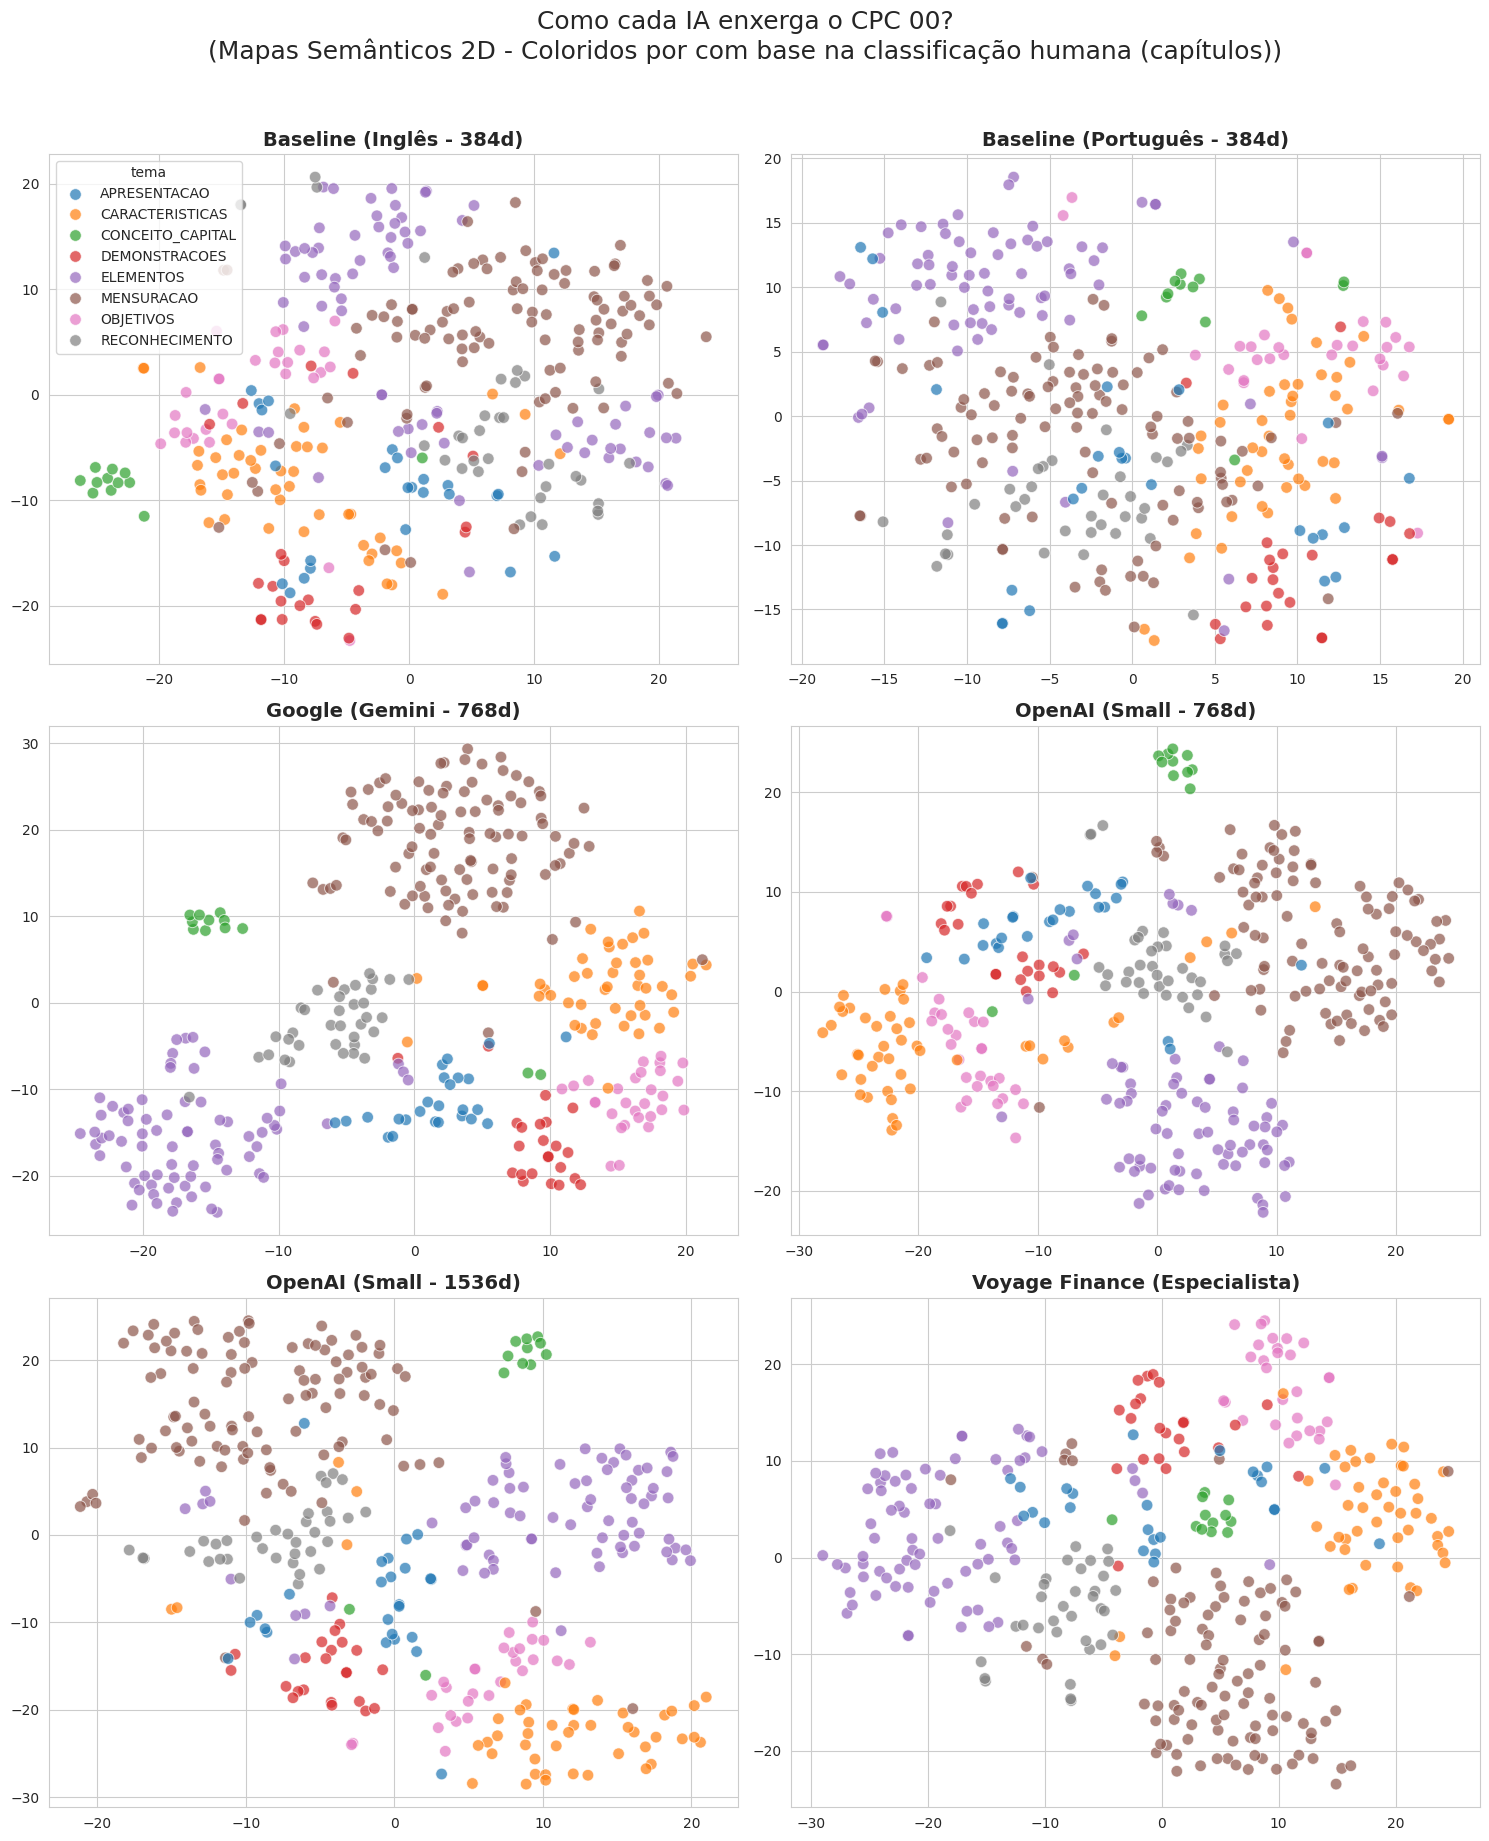

In [35]:
# --- CONFIGURAÇÃO VISUAL ---
# Defina aqui os modelos que você quer plotar (nomes das colunas no seu DF)
modelos_para_plotar = competidores

# Filtra apenas os que existem no DataFrame
modelos_validos = {k: v for k, v in modelos_para_plotar.items() if v in df.columns}
qtd = len(modelos_validos)

# Configura o tamanho do Grid (ex: 3 linhas x 2 colunas)
cols = 2
rows = math.ceil(qtd / cols)

plt.figure(figsize=(15, 6 * rows))
sns.set_style("whitegrid")

# Pega as cores únicas para manter consistência (ex: Capítulo 4 sempre Vermelho)
temas_unicos = sorted(df['tema'].unique())
palette = sns.color_palette("tab10", len(temas_unicos))

print("Gerando mapas t-SNE (Isso pode levar alguns segundos)...")

for i, (nome_modelo, col_vetor) in enumerate(modelos_validos.items()):
    ax = plt.subplot(rows, cols, i + 1)

    # 1. Prepara os dados
    matrix = np.vstack(df[col_vetor].values)

    # 2. Roda o t-SNE (Reduz de 768d/1536d para 2d)
    # random_state=42 garante que o desenho seja sempre o mesmo
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
    vis_dims = tsne.fit_transform(matrix)

    # 3. Plota
    sns.scatterplot(
        x=vis_dims[:, 0],
        y=vis_dims[:, 1],
        hue=df['tema'],
        hue_order=temas_unicos,
        palette=palette,
        s=70,         # Tamanho da bolinha
        alpha=0.7,    # Transparência
        ax=ax,
        legend=(i == 0) # Só mostra legenda no primeiro para não poluir
    )

    ax.set_title(f"{nome_modelo}", fontsize=14, fontweight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.suptitle("Como cada IA enxerga o CPC 00?\n(Mapas Semânticos 2D - Coloridos por com base na classificação humana (capítulos))", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


--- 📊 Calculando Indicador Composto de Performance (Metodologia OECD) ---
Calculando IA-Score com base em: ['Silhouette', 'ARI', 'Precision@5']


,Silhouette,ARI,Precision@5,Score Final (média),IA-Score Final (0-100)
Modelo,,,,,
Google (Gemini - 768d),0.0955,0.7198,0.8980,0.5711,100.0000
OpenAI (Small - 1536d),0.0543,0.4997,0.8455,0.4665,57.3173
OpenAI (Small - 768d),0.0552,0.4937,0.8415,0.4635,56.7378
Voyage Finance (Especialista),0.0565,0.4074,0.8040,0.4226,45.7888
Baseline (Português - 384d),0.0361,0.2408,0.6749,0.3173,5.2922
Baseline (Inglês - 384d),0.0256,0.2370,0.6755,0.3127,0.0861


/tmp/ipython-input-1120293765.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_metrics['Score Final (média)'], y=df_metrics.index, palette='magma')


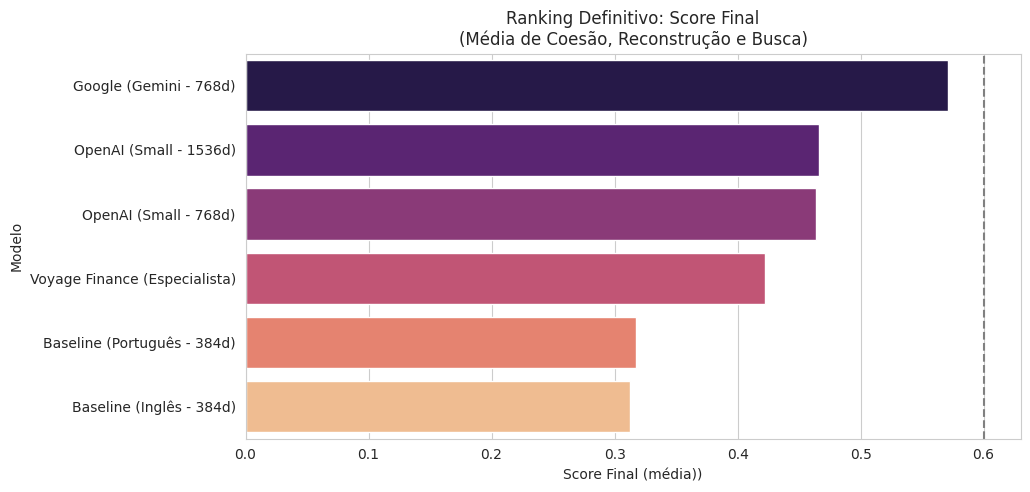

In [36]:
# ... (Importações anteriores mantidas)

print("\n--- 📊 Calculando Indicador Composto de Performance (Metodologia OECD) ---")

resultados_completos = []

# Garante que temos o número de clusters baseado no total (assumindo que não há nulos na coluna 'tema')
n_clusters_reais = len(df['tema'].unique())

def calculate_precision_at_k(X, y_real, k=5):
    # Simula um sistema de busca (RAG): Para cada ponto, acha os 5 vizinhos
    nbrs = NearestNeighbors(n_neighbors=k+1, metric='cosine').fit(X)
    indices = nbrs.kneighbors(X, return_distance=False)

    # O vizinho 0 é o próprio ponto, então pegamos do 1 ao k+1
    neighbor_indices = indices[:, 1:]

    y_true = np.array(y_real)
    neighbor_labels = y_true[neighbor_indices]
    correct_labels = y_true[:, None] # Transforma em coluna para comparar

    # Média de acertos (Precision)
    matches = (neighbor_labels == correct_labels)
    return np.mean(matches)

for nome, col in competidores.items():
    if col in df.columns:
        # --- SEGURANÇA 1: DROPNA ---
        # Crucial: Garante que X e y tenham o mesmo tamanho mesmo se a API falhou em 1 linha
        df_temp = df.dropna(subset=[col]).copy()

        # Pega os vetores e o gabarito alinhados
        X_bruto = np.vstack(df_temp[col].values)
        y_real = df_temp['tema']

        # --- A CORREÇÃO MÁGICA ---
        # Força norma L2 (Unitária) para todos.
        X = normalize(X_bruto, norm='l2')

        # 1. Clustering (K-Means para Teste Cego)
        kmeans = KMeans(n_clusters=n_clusters_reais, random_state=42, n_init=10)
        y_pred = kmeans.fit_predict(X)

        # Métricas
        sil = silhouette_score(X, y_real)
        db = davies_bouldin_score(X, y_real)
        ari = adjusted_rand_score(y_real, y_pred)
        prec = calculate_precision_at_k(X, y_real, k=5)

        resultados_completos.append({
            'Modelo': nome,
            'Silhouette': sil,
            'Davies-Bouldin': db,
            'ARI': ari,
            'Precision@5': prec
        })

df_metrics = pd.DataFrame(resultados_completos).set_index('Modelo')

# --- CÁLCULO DO INDICADOR COMPOSTO (IA-SCORE) ---
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df_metrics), columns=df_metrics.columns, index=df_metrics.index)

# Inverte Davies-Bouldin (Menor é melhor)
df_norm['Davies-Bouldin'] = 1 - df_norm['Davies-Bouldin']

# Cálculo da Média (IA-Score) SEM o Davies-Bouldin (Curadoria)
colunas_para_score = ['Silhouette', 'ARI', 'Precision@5']
print(f"Calculando IA-Score com base em: {colunas_para_score}")

df_metrics['Score Final (média)'] = df_metrics[colunas_para_score].mean(axis=1)
df_metrics['IA-Score Final (0-100)'] = df_norm[colunas_para_score].mean(axis=1) * 100

# Ordena pelo Score Final
df_metrics = df_metrics.sort_values('Score Final (média)', ascending=False)

# --- CORREÇÃO 2: COLCHETES DUPLOS ---
# Para selecionar uma lista de colunas, use [[...]]
colunas_finais = ['Silhouette', 'ARI', 'Precision@5', 'Score Final (média)', 'IA-Score Final (0-100)']
df_metrics = df_metrics[colunas_finais]

# Exibição Bonita
display(df_metrics.style.background_gradient(cmap='viridis', subset=['Score Final (média)'])
                  .format("{:.4f}"))


# GRÁFICO FINAL DO SCORE
plt.figure(figsize=(10, 5))
sns.barplot(x=df_metrics['Score Final (média)'], y=df_metrics.index, palette='magma')
plt.title('Ranking Definitivo: Score Final\n(Média de Coesão, Reconstrução e Busca)')
plt.xlabel("Score Final (média))")
plt.axvline(0.6, color='grey', linestyle='--')
plt.show()